# This notebook is for Mahalanobis distance (multiple sensors) results on train & two test sets (normal & faulty vehicle) for rough road surface

In [25]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
import math
import csv

# Import and read train (subset of Feb - normal vehicle) set

In [72]:
data_vib1 = pd.read_csv("Input_Data_Files/RoughDataTrain.csv", index_col=0)
data_vib1

,FR_LH [m/s2],FR_RH [m/s2],RR_LH [m/s2],RR_RH [m/s2],Cabin [m/s2]
DateTime,,,,,
2020-02-25 16:40:05.600,3.076945,2.005210,0.794605,0.253525,0.680249
2020-02-25 16:40:05.605,-0.643661,-1.515605,1.031323,0.139600,0.285827
2020-02-25 16:40:05.610,2.836121,3.578015,0.940638,0.474731,0.223586
2020-02-25 16:40:05.615,0.456141,-1.551423,1.076140,0.735006,0.603429
2020-02-25 16:40:05.620,0.245845,0.819562,1.121251,0.500910,-0.625381
...,...,...,...,...,...
2020-02-25 15:25:44.810,-2.441289,-0.014932,-0.664579,1.031195,3.263141
2020-02-25 15:25:44.815,1.175209,8.271926,-1.097748,0.689503,1.028962
2020-02-25 15:25:44.820,-2.777858,3.400182,-2.190061,1.966211,-3.580245


In [27]:
data_vib1.describe()

,FR_LH [m/s2],FR_RH [m/s2],RR_LH [m/s2],RR_RH [m/s2],Cabin [m/s2]
count,164932.000000,164932.000000,164932.000000,164932.000000,164932.000000
mean,0.550577,0.237977,-0.135947,0.270000,0.050633
std,5.136429,4.970875,4.152703,3.933036,4.419613
min,-31.031094,-25.707024,-19.261927,-17.045338,-24.771814
25%,-2.678184,-2.956743,-2.946390,-2.366574,-2.725359
50%,0.779768,0.403908,-0.128910,0.228250,0.230190
75%,4.050982,3.598978,2.678713,2.854316,3.054939
max,24.235014,22.461040,21.390955,23.162222,19.084988


array([<AxesSubplot:xlabel='DateTime'>, <AxesSubplot:xlabel='DateTime'>,
       <AxesSubplot:xlabel='DateTime'>, <AxesSubplot:xlabel='DateTime'>,
       <AxesSubplot:xlabel='DateTime'>], dtype=object)

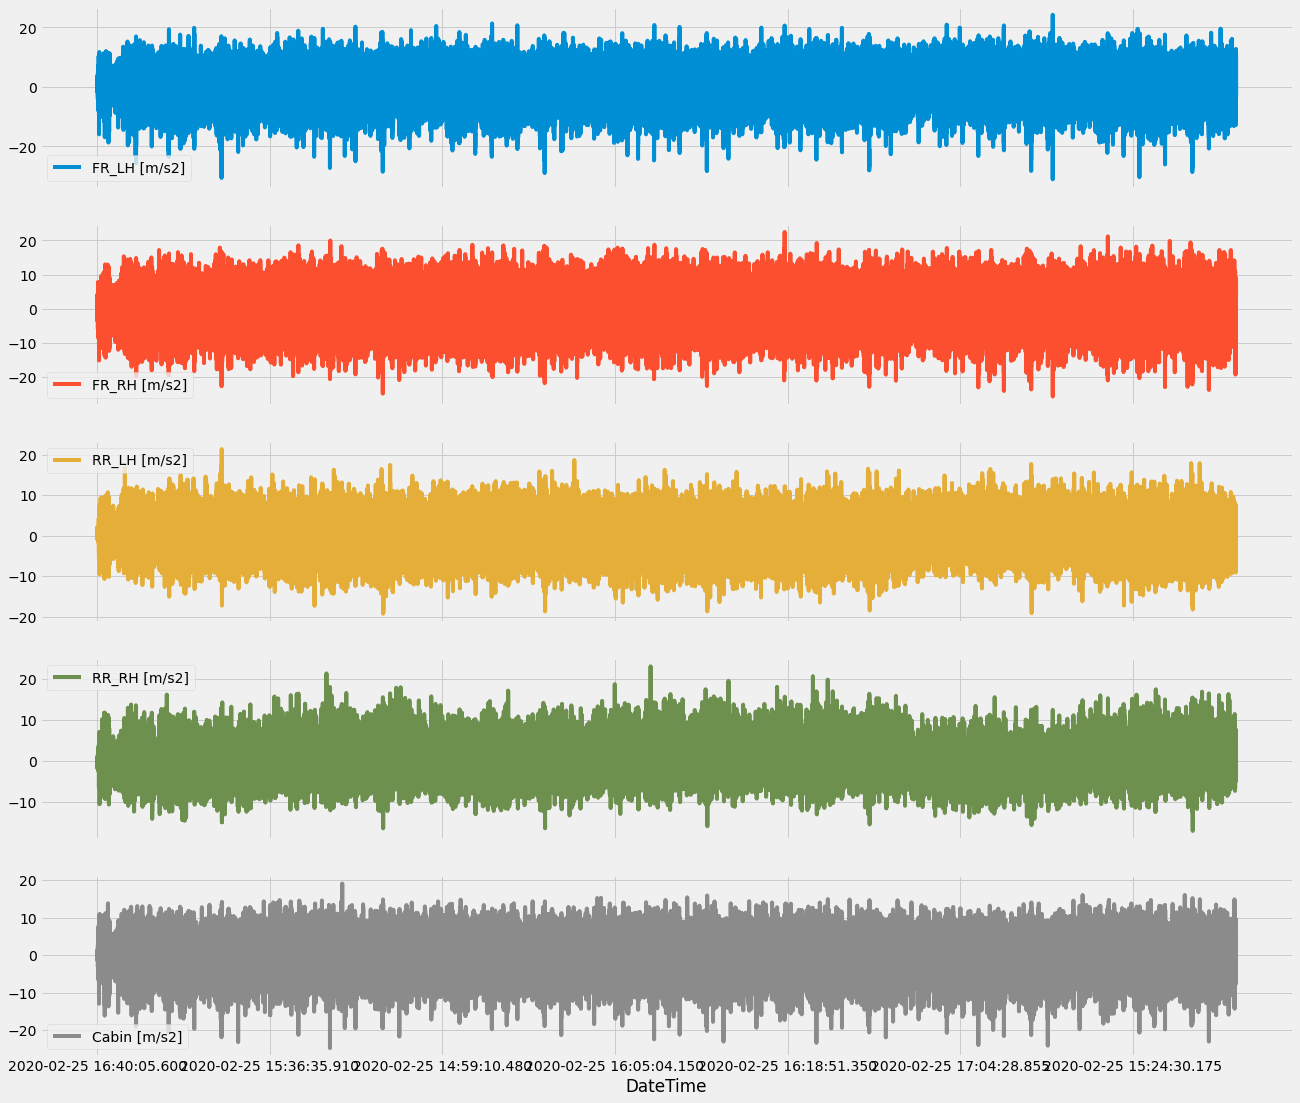

In [28]:
plt.style.use('fivethirtyeight')
data_vib1.plot(figsize=(20,18), subplots=True)

# Time domain feature extraction (7 features) function

In [29]:
def time_domain_features(test1,w,overlap):
    columns = test1.columns
    for c in range (len(columns)):
        for i in range(0,test1.shape[0]-(w-1),overlap):
            test1.loc[test1.index[i+w-1],'mean_'+str(c)] = test1.iloc[i:i+w,c].mean()
            test1.loc[test1.index[i+w-1],'var_'+str(c)] = test1.iloc[i:i+w,c].var()
            test1.loc[test1.index[i+w-1],'skew_'+str(c)] = test1.iloc[i:i+w,c].skew()
            test1.loc[test1.index[i+w-1],'kurtosis_'+str(c)] = test1.iloc[i:i+w,c].kurtosis()
            test1.loc[test1.index[i+w-1],'peak_'+str(c)] = np.max(np.abs(test1.iloc[i:i+w,c]))
            test1.loc[test1.index[i+w-1],'rms_'+str(c)] = np.sqrt(np.mean(np.square(test1.iloc[i:i+w,c])))
            test1.loc[test1.index[i+w-1],'crest_'+str(c)] = (np.max(np.abs(test1.iloc[i:i+w,c])))/(np.sqrt(np.mean(np.square(test1.iloc[i:i+w,c]))))
    return (test1)    

# Feature extraction (7 features for each sensor) of train set (total 35 features)

In [30]:
data_vib2 = time_domain_features(data_vib1,2000,250)
data_vib2 = data_vib2.dropna()
data_vib2

,FR_LH [m/s2],FR_RH [m/s2],RR_LH [m/s2],RR_RH [m/s2],Cabin [m/s2],mean_0,var_0,skew_0,kurtosis_0,peak_0,...,peak_3,rms_3,crest_3,mean_4,var_4,skew_4,kurtosis_4,peak_4,rms_4,crest_4
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-02-25 16:43:31.105,1.143126,-3.769742,-0.918651,-0.516554,-0.239806,0.805269,17.273123,-0.270549,0.464985,18.691126,...,11.846721,3.293102,3.597435,-0.019104,14.359297,-0.219569,0.632059,16.123936,3.788467,4.256058
2020-02-25 16:43:32.355,-2.805761,-2.997229,3.138828,0.787321,-0.829528,0.683561,16.839261,-0.223443,0.526853,18.691126,...,11.846721,3.302323,3.587390,-0.069442,14.029472,-0.208910,0.710439,16.123936,3.745301,4.305111
2020-02-25 16:43:33.605,-0.223364,-0.147470,-0.272563,0.591831,0.286845,0.679160,15.455854,-0.152287,0.636960,18.691126,...,11.846721,3.082285,3.843486,-0.002257,12.635500,-0.202033,0.908413,16.123936,3.553757,4.537152
2020-02-25 16:43:34.855,2.365210,2.041997,0.936763,0.693119,0.459675,0.550703,14.714156,-0.130718,0.827209,18.691126,...,11.846721,3.014121,3.930407,-0.060725,12.053453,-0.197633,1.152888,16.123936,3.471471,4.644698
2020-02-25 16:43:36.105,2.688500,1.435560,-0.767101,-1.358798,2.131524,0.533184,13.564542,-0.142150,1.046993,18.691126,...,11.846721,2.966035,3.994128,0.000869,11.230821,-0.283834,1.431918,16.123936,3.350404,4.812535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-25 15:25:38.920,0.835089,4.301336,3.406294,1.676898,-0.597635,0.283449,25.131495,-0.238576,0.111485,19.590591,...,16.146078,4.077573,3.959727,0.174035,18.231849,-0.190075,0.008794,16.014780,4.272355,3.748466
2020-02-25 15:25:40.170,6.755424,1.643325,-7.000025,-4.190005,4.980078,0.284157,25.693722,-0.245781,0.094450,19.590591,...,16.390362,4.118774,3.979428,0.188431,18.413550,-0.289758,0.131756,16.014780,4.294165,3.729429
2020-02-25 15:25:41.420,-8.583918,-5.479829,-2.082022,-0.396489,0.662057,0.251719,25.310098,-0.226144,0.172248,19.590591,...,16.390362,4.041764,4.055250,0.188211,17.800981,-0.295943,0.047018,15.846685,4.222263,3.753126


                           mean_0      var_0    skew_0  kurtosis_0     peak_0  \
DateTime                                                                        
2020-02-25 16:43:31.105  0.805269  17.273123 -0.270549    0.464985  18.691126   
2020-02-25 16:43:32.355  0.683561  16.839261 -0.223443    0.526853  18.691126   
2020-02-25 16:43:33.605  0.679160  15.455854 -0.152287    0.636960  18.691126   
2020-02-25 16:43:34.855  0.550703  14.714156 -0.130718    0.827209  18.691126   
2020-02-25 16:43:36.105  0.533184  13.564542 -0.142150    1.046993  18.691126   

                            rms_0   crest_0    mean_1      var_1    skew_1  \
DateTime                                                                     
2020-02-25 16:43:31.105  4.232369  4.416233  0.294762  16.007497 -0.298229   
2020-02-25 16:43:32.355  4.159098  4.494034  0.216514  15.545511 -0.265701   
2020-02-25 16:43:33.605  3.988657  4.686070  0.247932  14.512545 -0.231261   
2020-02-25 16:43:34.855  3.874283  4.82440

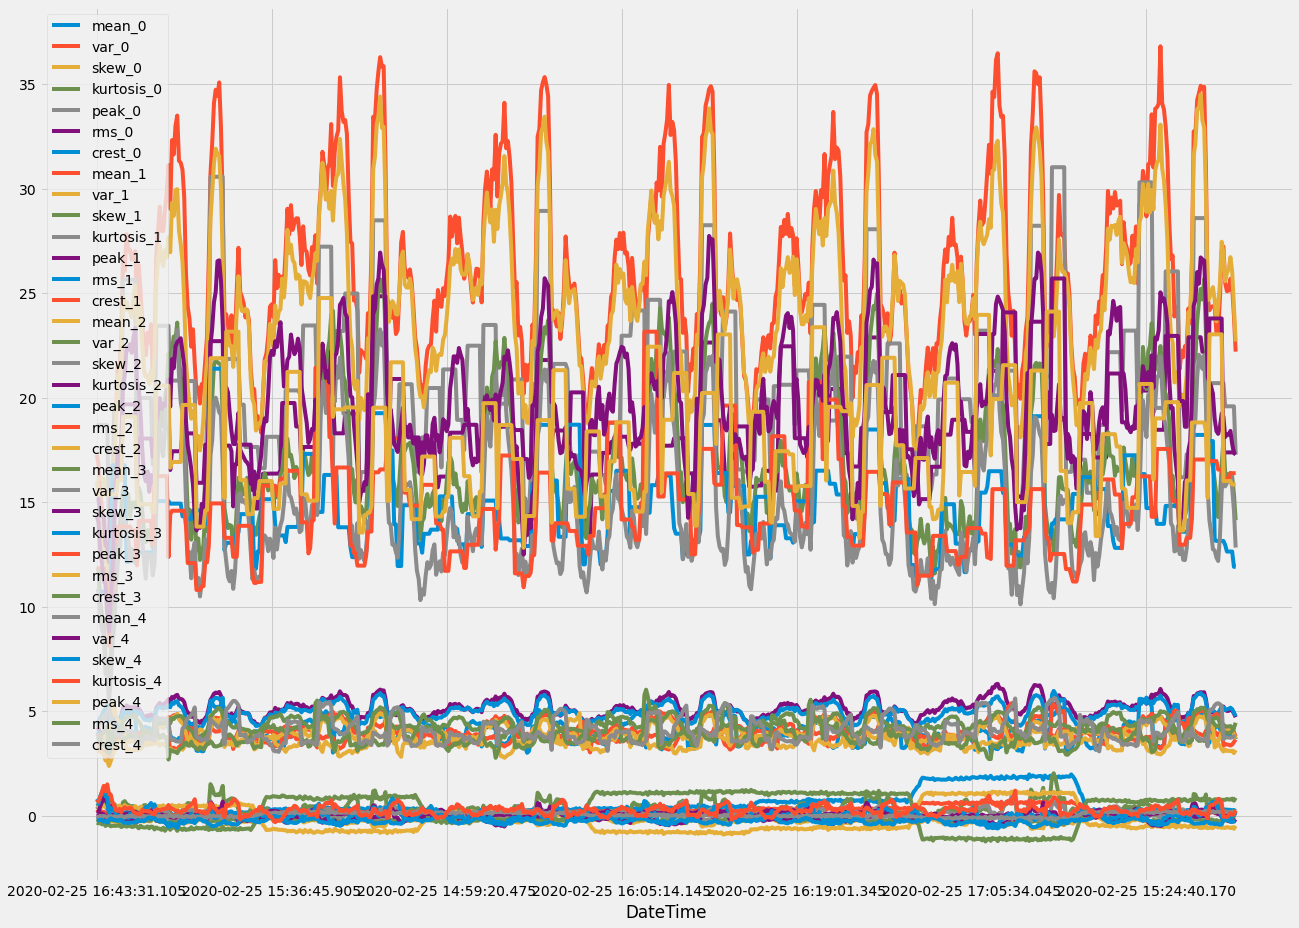

In [31]:
plt.style.use('fivethirtyeight')
data_vib = data_vib2.iloc[:,5:40]
print(data_vib.head())
data_vib.plot(figsize=(20,15))
plt.show()

In [32]:
columns = data_vib.columns
columns

Index(['mean_0', 'var_0', 'skew_0', 'kurtosis_0', 'peak_0', 'rms_0', 'crest_0',
       'mean_1', 'var_1', 'skew_1', 'kurtosis_1', 'peak_1', 'rms_1', 'crest_1',
       'mean_2', 'var_2', 'skew_2', 'kurtosis_2', 'peak_2', 'rms_2', 'crest_2',
       'mean_3', 'var_3', 'skew_3', 'kurtosis_3', 'peak_3', 'rms_3', 'crest_3',
       'mean_4', 'var_4', 'skew_4', 'kurtosis_4', 'peak_4', 'rms_4',
       'crest_4'],
      dtype='object')

# Feature selection of train set using PCA (reduced to 10 features)

Text(0.5, 1.0, 'PCA Explained Variance vs. N Componets')

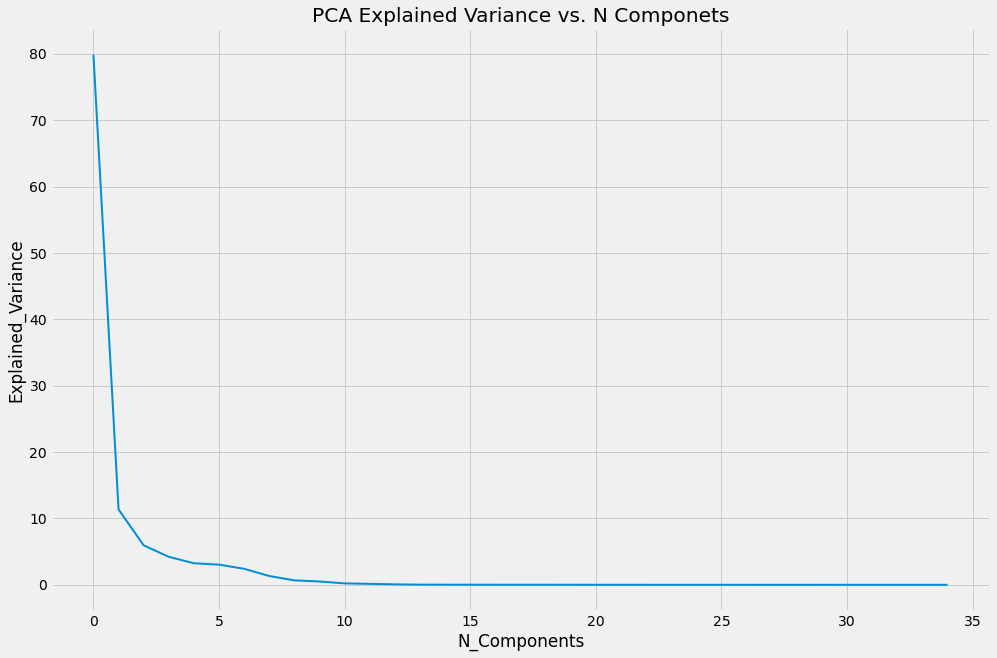

In [33]:
plt.style.use('fivethirtyeight')
from sklearn.decomposition import PCA

#find explained variance and n_components
pca = PCA()
fit = pca.fit(data_vib)
plt.figure(figsize=(15, 10))
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('N_Components')
plt.ylabel('Explained_Variance')
plt.title('PCA Explained Variance vs. N Componets')

Explained Variance: [7.06338800e-01 1.00427399e-01 5.25606085e-02 3.72471958e-02
 2.87451615e-02 2.68358322e-02 2.12992064e-02 1.17125281e-02
 5.85856046e-03 4.39183004e-03 1.88757191e-03 1.24573631e-03
 6.10975022e-04 1.94563490e-04 1.61775707e-04 1.01282743e-04
 6.92787937e-05 6.26839224e-05 5.25820561e-05 3.72511645e-05
 3.42300295e-05 2.26629554e-05 2.00532021e-05 1.62675507e-05
 1.41492270e-05 1.20251125e-05 1.05482770e-05 9.38800420e-06
 6.89405230e-06 4.99851656e-06 4.02490352e-06 2.09388676e-06
 8.81910812e-07 6.60520855e-07 2.99178707e-07]


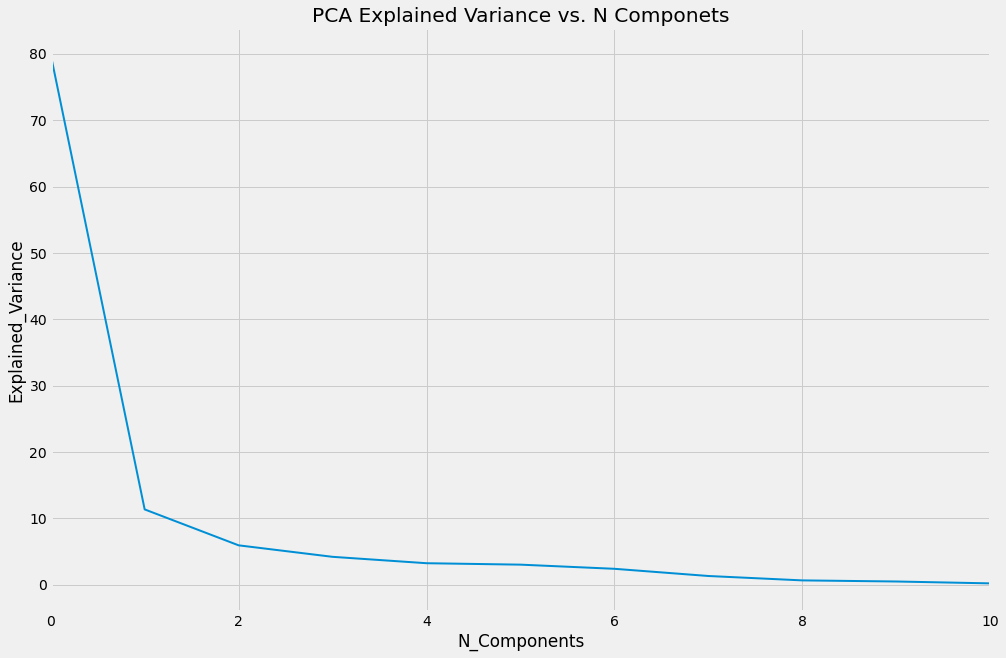

In [34]:
from sklearn.decomposition import PCA

#find explained variance and n_components
pca = PCA()
fit = pca.fit(data_vib)
plt.figure(figsize=(15, 10))
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('N_Components')
plt.ylabel('Explained_Variance')
plt.xlim(0, 10)
plt.title('PCA Explained Variance vs. N Componets')

print("Explained Variance: %s" % fit.explained_variance_ratio_)

In [35]:
pca = PCA(n_components=10)
fit = pca.fit(data_vib)
print("Explained Variance: %s" % fit.explained_variance_ratio_)
print(fit.components_)

Explained Variance: [0.7063388  0.1004274  0.05256061 0.0372472  0.02874516 0.02683583
 0.02129921 0.01171253 0.00585856 0.00439183]
[[ 2.82676872e-03 -4.87748985e-01  7.08513191e-03 -1.13051123e-02
  -3.39118479e-01 -4.67556243e-02 -2.75432983e-02  6.58922576e-04
  -4.38852134e-01  4.57690476e-03 -1.92425950e-03 -1.93332860e-01
  -4.43039861e-02 -4.70437047e-03  1.22651173e-02 -3.41224686e-01
   3.40213052e-03  2.44897539e-03 -1.47993759e-01 -4.09588744e-02
   1.31319674e-04 -1.39394143e-02 -3.39856252e-01  7.79459096e-04
   6.69853677e-03 -1.57881694e-01 -4.33582195e-02  6.83240761e-04
  -2.09520760e-03 -3.05942544e-01  6.98767404e-03 -9.66574049e-04
  -1.85205367e-01 -3.47666160e-02 -9.70059279e-03]
 [ 3.25500229e-02 -1.71477146e-01 -1.05242855e-02  7.43988472e-02
   6.47036990e-01 -9.98541970e-03  1.31409922e-01  7.53271971e-03
  -1.73635598e-01 -8.19332377e-03  3.19660756e-02  2.78504029e-01
  -1.72226036e-02  6.83908141e-02  4.52636691e-02 -2.42519245e-01
  -5.14893676e-03  2.649

In [36]:
pca = PCA(n_components=10)
data_vib = pca.fit_transform(data_vib)
data_vib.shape

(652, 10)

In [37]:
data_vib = pd.DataFrame(data_vib)
data_vib.columns=['0','1','2','3','4','5','6','7','8','9']
data_vib

,0,1,2,3,4,5,6,7,8,9
0,16.109228,2.599557,0.288964,0.884746,1.722718,-2.506217,0.657732,-1.426946,0.854971,0.969513
1,16.596652,2.777317,0.201798,1.186064,2.070025,-2.438282,0.691777,-1.620446,0.922189,1.004212
2,19.371435,3.924995,0.090706,1.876915,1.808580,-2.661791,0.526595,-0.676731,0.809254,0.688651
3,20.712625,4.622116,0.004481,2.247577,1.874734,-2.475627,0.535499,-0.710540,0.985421,0.482419
4,22.002757,5.233668,-0.144263,2.811149,2.225817,-2.232836,0.667279,-0.594667,0.880997,0.770993
...,...,...,...,...,...,...,...,...,...,...
647,1.498432,-2.897796,-0.526933,1.092041,-0.413899,-1.477919,2.227899,0.935613,-1.000700,1.053491
648,0.669127,-3.287990,-0.603955,1.027855,-0.489511,-1.566964,2.367926,1.148488,-1.027673,1.007209
649,1.695442,-2.889999,-0.538731,1.348537,-0.489801,-1.412151,2.463948,1.146425,-0.945671,0.682336
650,4.008368,-1.810074,-0.858712,1.576391,-0.740327,-1.550386,2.718228,0.490597,-0.619440,0.687084


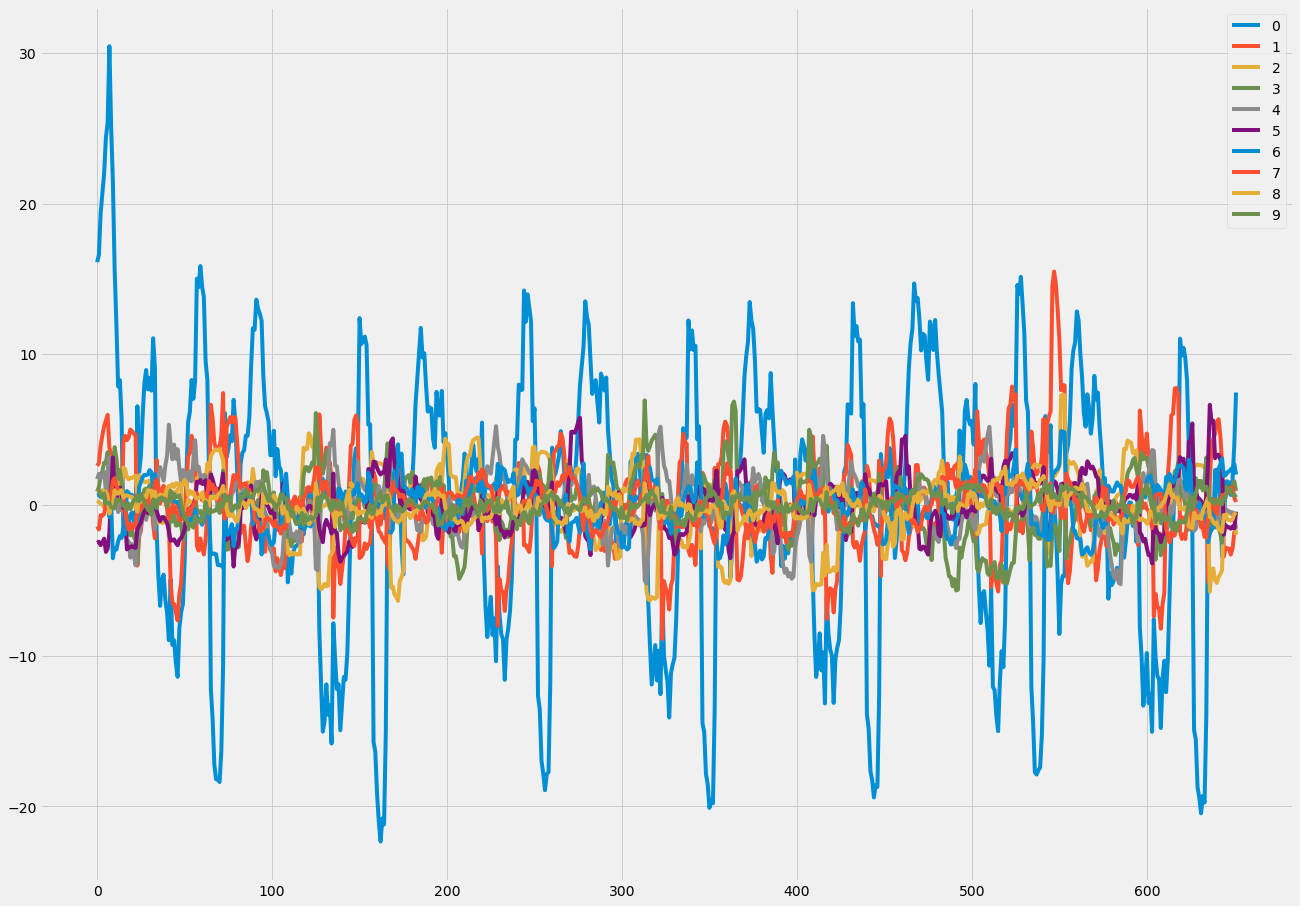

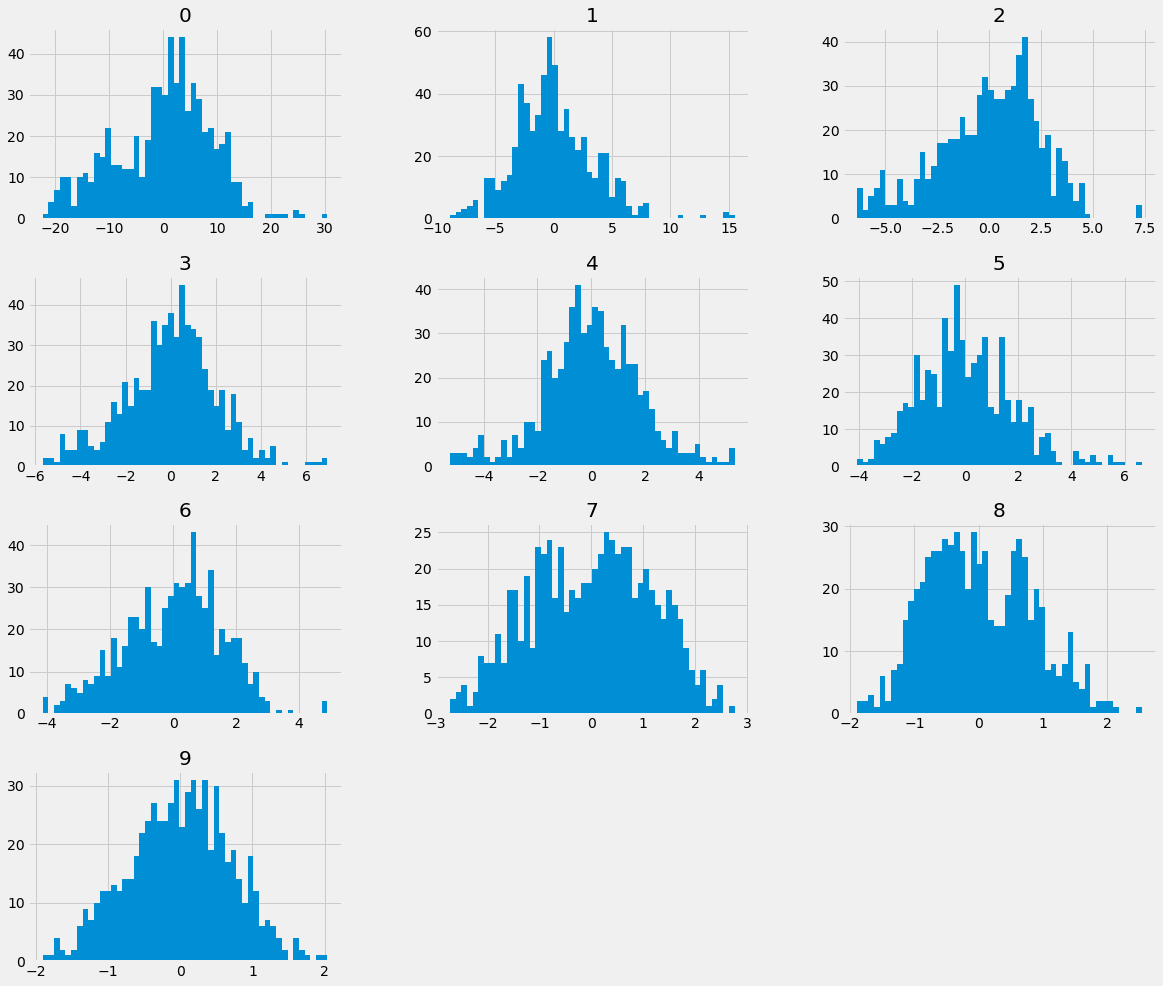

In [38]:
data_vib.plot(figsize=(20,15))
data_vib.hist(bins=50, figsize=(18,16))
plt.show()

In [73]:
plt.figure(figsize=(15, 10))
import plotly.express as px
fig = px.scatter_matrix(data_vib)
fig.show()

<Figure size 1080x720 with 0 Axes>

# Import and read test (subset of Feb - normal vehicle) set

In [74]:
data = pd.read_csv("Input_Data_Files/RoughDataTest_Feb.csv", index_col=0)
data

,FR_LH [m/s2],FR_RH [m/s2],RR_LH [m/s2],RR_RH [m/s2],Cabin [m/s2]
DateTime,,,,,
2020-02-25 15:02:23.430,-8.365533,-6.024143,-6.996150,-3.959084,0.104379
2020-02-25 15:02:23.435,-11.155451,-2.192894,-5.360354,-4.869436,-3.251968
2020-02-25 15:02:23.440,-9.144586,-6.445586,-8.112810,-4.643099,-11.036530
2020-02-25 15:02:23.445,-1.243389,-7.474725,-3.406589,-1.470600,-13.574854
2020-02-25 15:02:23.450,-4.011792,-6.015308,-7.426538,-4.181741,-13.558696
...,...,...,...,...,...
2020-02-25 17:10:11.745,5.369437,-5.901467,3.192574,0.037849,1.845282
2020-02-25 17:10:11.750,-2.640386,-7.980957,4.946055,-1.059476,1.054901
2020-02-25 17:10:11.755,-7.514707,-5.436108,2.104472,-2.563446,-1.928436


In [42]:
data.describe()

,FR_LH [m/s2],FR_RH [m/s2],RR_LH [m/s2],RR_RH [m/s2],Cabin [m/s2]
count,187517.000000,187517.000000,187517.000000,187517.000000,187517.000000
mean,0.752771,0.295051,-0.041388,0.136587,0.053035
std,5.164089,5.002301,4.178139,3.954201,4.454828
min,-31.671457,-25.889437,-20.499136,-18.982910,-24.831045
25%,-2.498753,-2.925361,-2.882398,-2.494624,-2.752378
50%,1.002922,0.454955,-0.038456,0.106208,0.235195
75%,4.277220,3.697858,2.788680,2.740159,3.102170
max,22.476803,22.801096,18.606867,22.795959,18.714262


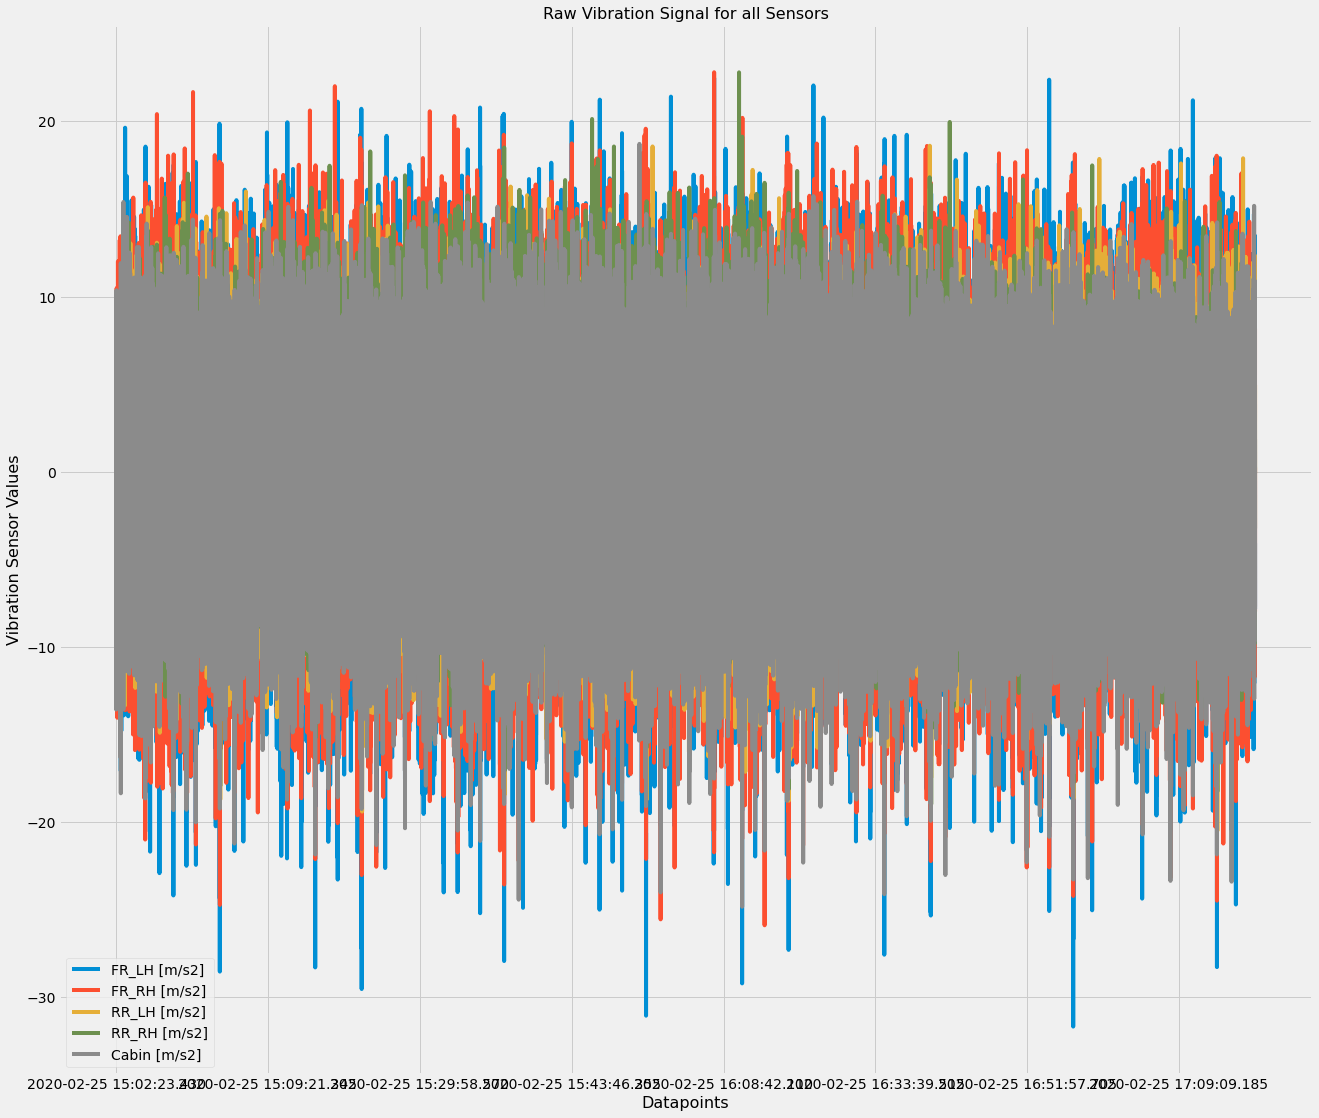

In [43]:
plt.style.use('fivethirtyeight')
ax = data.plot(figsize=(20,18), subplots=False)
ax.set_xlabel('Datapoints', fontsize=16)
ax.set_ylabel('Vibration Sensor Values', fontsize=16)
ax.set_title('Raw Vibration Signal for all Sensors', fontsize=16)
plt.show()

In [44]:
data_test_new = data.reset_index()
data_test1 = data_test_new.iloc[:,1:6]
data_test1

,FR_LH [m/s2],FR_RH [m/s2],RR_LH [m/s2],RR_RH [m/s2],Cabin [m/s2]
0,-8.365533,-6.024143,-6.996150,-3.959084,0.104379
1,-11.155451,-2.192894,-5.360354,-4.869436,-3.251968
2,-9.144586,-6.445586,-8.112810,-4.643099,-11.036530
3,-1.243389,-7.474725,-3.406589,-1.470600,-13.574854
4,-4.011792,-6.015308,-7.426538,-4.181741,-13.558696
...,...,...,...,...,...
187512,5.369437,-5.901467,3.192574,0.037849,1.845282
187513,-2.640386,-7.980957,4.946055,-1.059476,1.054901
187514,-7.514707,-5.436108,2.104472,-2.563446,-1.928436
187515,-7.831190,-0.595201,4.600119,0.272533,-3.949953


# Feature extraction (7 features for each sensor) of test set (total 35 features)

In [45]:
data_test1_new = time_domain_features(data_test1,2000,250)
data_test1_new

,FR_LH [m/s2],FR_RH [m/s2],RR_LH [m/s2],RR_RH [m/s2],Cabin [m/s2],mean_0,var_0,skew_0,kurtosis_0,peak_0,...,peak_3,rms_3,crest_3,mean_4,var_4,skew_4,kurtosis_4,peak_4,rms_4,crest_4
0,-8.365533,-6.024143,-6.996150,-3.959084,0.104379,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-11.155451,-2.192894,-5.360354,-4.869436,-3.251968,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-9.144586,-6.445586,-8.112810,-4.643099,-11.036530,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1.243389,-7.474725,-3.406589,-1.470600,-13.574854,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-4.011792,-6.015308,-7.426538,-4.181741,-13.558696,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187512,5.369437,-5.901467,3.192574,0.037849,1.845282,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187513,-2.640386,-7.980957,4.946055,-1.059476,1.054901,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187514,-7.514707,-5.436108,2.104472,-2.563446,-1.928436,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187515,-7.831190,-0.595201,4.600119,0.272533,-3.949953,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(743, 36)
                     DateTime    mean_0      var_0    skew_0  kurtosis_0  \
1999  2020-02-25 15:02:33.425  0.343062  21.554373 -0.165787    0.327917   
2249  2020-02-25 15:02:34.675  0.373264  22.359879 -0.182461    0.234800   
2499  2020-02-25 15:02:35.925  0.422745  23.844844 -0.166243    0.054911   
2749  2020-02-25 15:02:37.175  0.355933  23.424869 -0.125019    0.130346   
2999  2020-02-25 15:02:38.425  0.412974  22.585305 -0.052842    0.027480   

         peak_0     rms_0   crest_0    mean_1      var_1  ...     peak_3  \
1999  19.635387  4.654169  4.218882  0.170748  20.920179  ...  13.387111   
2249  19.635387  4.742154  4.140605  0.188278  21.382982  ...  14.221837   
2499  19.635387  4.900167  4.007085  0.227874  21.921075  ...  14.221837   
2749  19.635387  4.851788  4.047042  0.191612  21.193903  ...  14.221837   
2999  19.635387  4.769126  4.117188  0.251003  20.722670  ...  14.221837   

         rms_3   crest_3    mean_4      var_4    skew_4  kurtosis_4  \
1999 

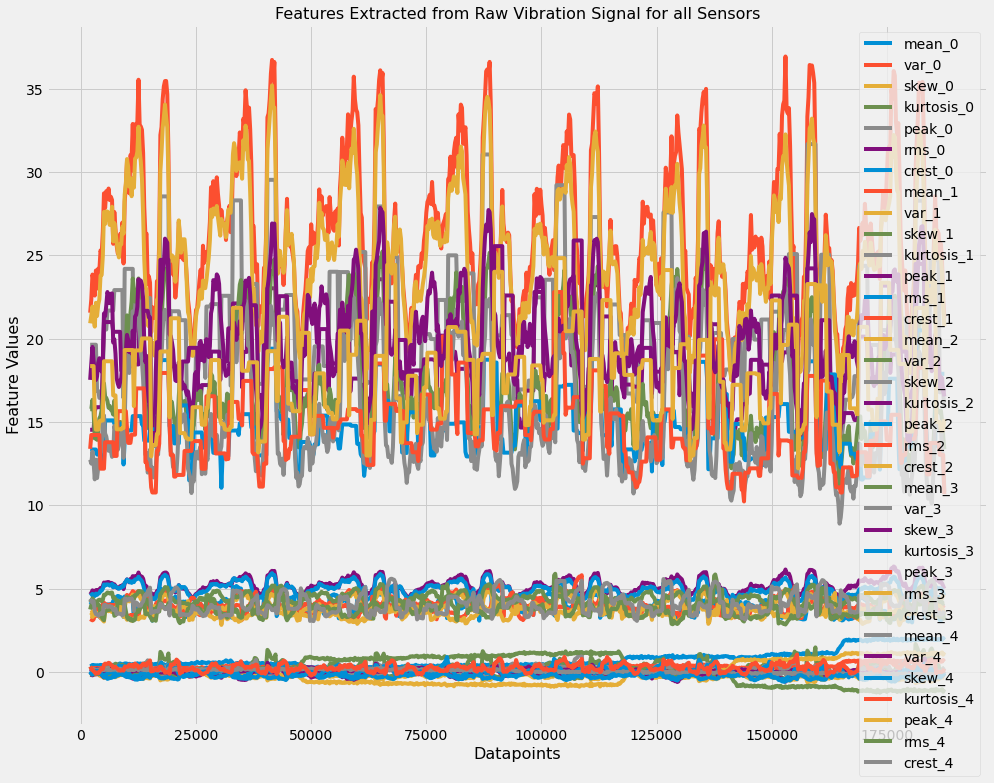

In [46]:
data_new = data_test1_new.iloc[:,5:40]
data_new = pd.concat([data_test_new.loc[:,'DateTime'], data_new], axis=1 )
data_new = data_new.dropna()
print(data_new.shape)
print(data_new.head())
ax=data_new.plot(figsize=(15,12))
ax.set_xlabel('Datapoints', fontsize=16)
ax.set_ylabel('Feature Values', fontsize=16)
ax.set_title('Features Extracted from Raw Vibration Signal for all Sensors', fontsize=16)
plt.show()

In [47]:
data_new_date=data_new[['DateTime']]
data_new_date

,DateTime
1999,2020-02-25 15:02:33.425
2249,2020-02-25 15:02:34.675
2499,2020-02-25 15:02:35.925
2749,2020-02-25 15:02:37.175
2999,2020-02-25 15:02:38.425
...,...
186499,2020-02-25 17:10:06.680
186749,2020-02-25 17:10:07.930
186999,2020-02-25 17:10:09.180
187249,2020-02-25 17:10:10.430


# Feature selection of test set using PCA (reduced to 10 features)

In [48]:
pca = PCA(n_components=10)
fit1 = pca.fit(data_new.iloc[:,1:36])
print("Explained Variance: %s" % fit1.explained_variance_ratio_)
print(fit1.components_)

Explained Variance: [0.70148772 0.10402288 0.04834981 0.03719522 0.03265927 0.02749028
 0.02017358 0.01326899 0.00831007 0.00400375]
[[-7.60554913e-03  4.80172774e-01 -7.03425415e-03  1.45142319e-02
   3.52031974e-01  4.39241707e-02  3.26098400e-02 -1.99789207e-03
   4.35469301e-01 -5.70257126e-03  4.32221029e-03  2.02988062e-01
   4.29194624e-02  7.78315440e-03 -1.20479646e-02  3.42845927e-01
  -4.68424325e-03 -9.37034734e-04  1.34865794e-01  3.96953336e-02
  -1.83792124e-03  1.17177908e-02  3.55846016e-01 -2.01212304e-03
  -2.32056016e-03  1.72281864e-01  4.36887754e-02  3.00719179e-03
   2.38998369e-03  2.77392413e-01 -8.36815002e-03  6.49995623e-03
   1.87923145e-01  3.07928975e-02  1.49132875e-02]
 [ 1.55780457e-02 -2.05823331e-01 -1.06382465e-02  6.20655101e-02
   4.89706572e-01 -1.57150879e-02  1.05074547e-01  3.72092277e-03
  -1.78922626e-01 -6.73365349e-03  3.20380678e-02  3.79205970e-01
  -1.67728015e-02  8.91063297e-02  1.30302020e-02 -2.38526288e-01
  -1.60675976e-03  1.895

In [49]:
pca = PCA(n_components=10)
data_new = pca.fit_transform(data_new.iloc[:,1:36])
data_new.shape

(743, 10)

In [50]:
data_new = pd.DataFrame(data_new)
data_new.columns=['0','1','2','3','4','5','6','7','8','9']
data_new = pd.concat([data_new_date.loc[:,'DateTime'], data_new.set_index(data_new_date.index)], axis=1, ignore_index=False)
data_new

,DateTime,0,1,2,3,4,5,6,7,8,9
1999,2020-02-25 15:02:33.425,-8.091122,0.346073,-0.604910,-0.438281,3.709046,-1.805398,0.691421,0.330119,-0.446319,0.626459
2249,2020-02-25 15:02:34.675,-7.162859,0.142536,-0.765924,-0.385001,2.925627,-2.810661,0.483741,0.118162,-0.188763,0.491914
2499,2020-02-25 15:02:35.925,-5.485486,-0.729280,-0.903915,-0.997671,2.681826,-3.041557,0.439074,0.260543,0.250738,0.168311
2749,2020-02-25 15:02:37.175,-6.743446,-0.050601,-0.672872,-0.692609,2.750623,-2.892830,0.377443,-0.000453,0.301113,-0.275867
2999,2020-02-25 15:02:38.425,-8.824884,-0.434766,1.621129,0.645526,0.952861,-2.197297,-0.086249,-0.019096,0.566721,-0.132332
...,...,...,...,...,...,...,...,...,...,...,...
186499,2020-02-25 17:10:06.680,-4.675945,-4.345227,-0.024066,0.348813,-0.803409,1.712643,2.913763,-3.113133,-0.563923,-0.164109
186749,2020-02-25 17:10:07.930,-4.406178,-4.868953,0.324068,0.410927,-0.906022,1.809339,2.784313,-3.090292,-0.267742,-0.490099
186999,2020-02-25 17:10:09.180,-5.946768,-3.987603,0.466620,0.621608,-1.238150,1.389170,3.078738,-2.909956,-0.301507,-0.333078
187249,2020-02-25 17:10:10.430,-8.919634,-2.456192,0.595244,1.361965,-1.070185,1.302764,3.627544,-2.525880,0.040414,-0.143456


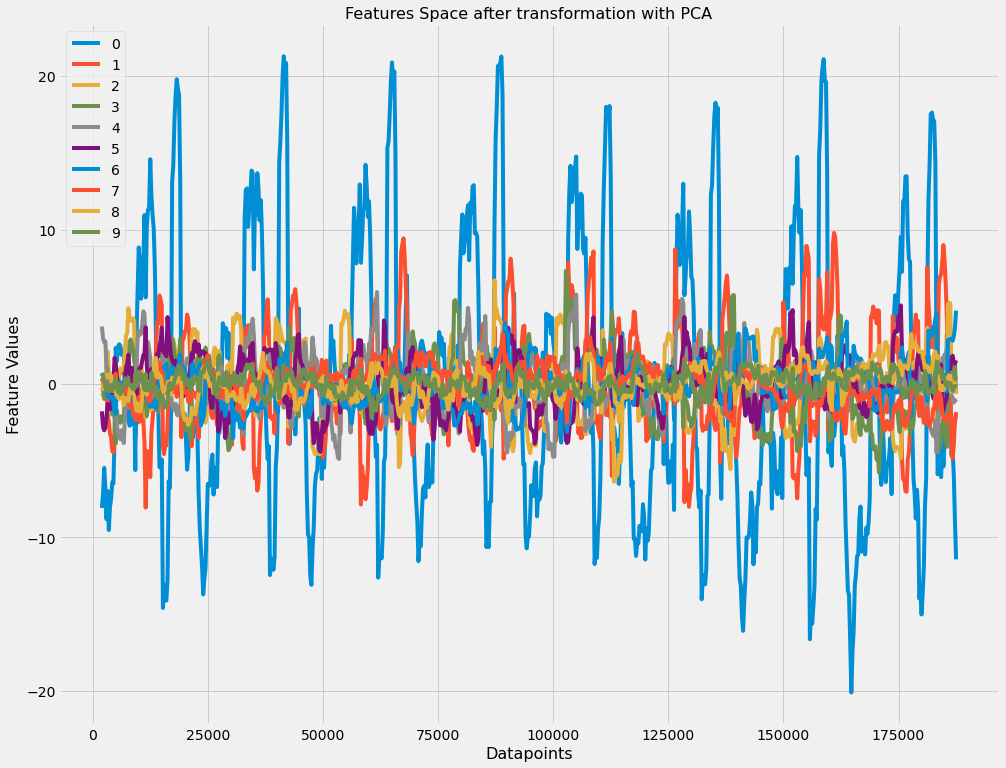

In [51]:
ax=data_new.plot(figsize=(15,12))
ax.set_xlabel('Datapoints', fontsize=16)
ax.set_ylabel('Feature Values', fontsize=16)
ax.set_title('Features Space after transformation with PCA', fontsize=16)
plt.show()

# Correlation matrix visualization

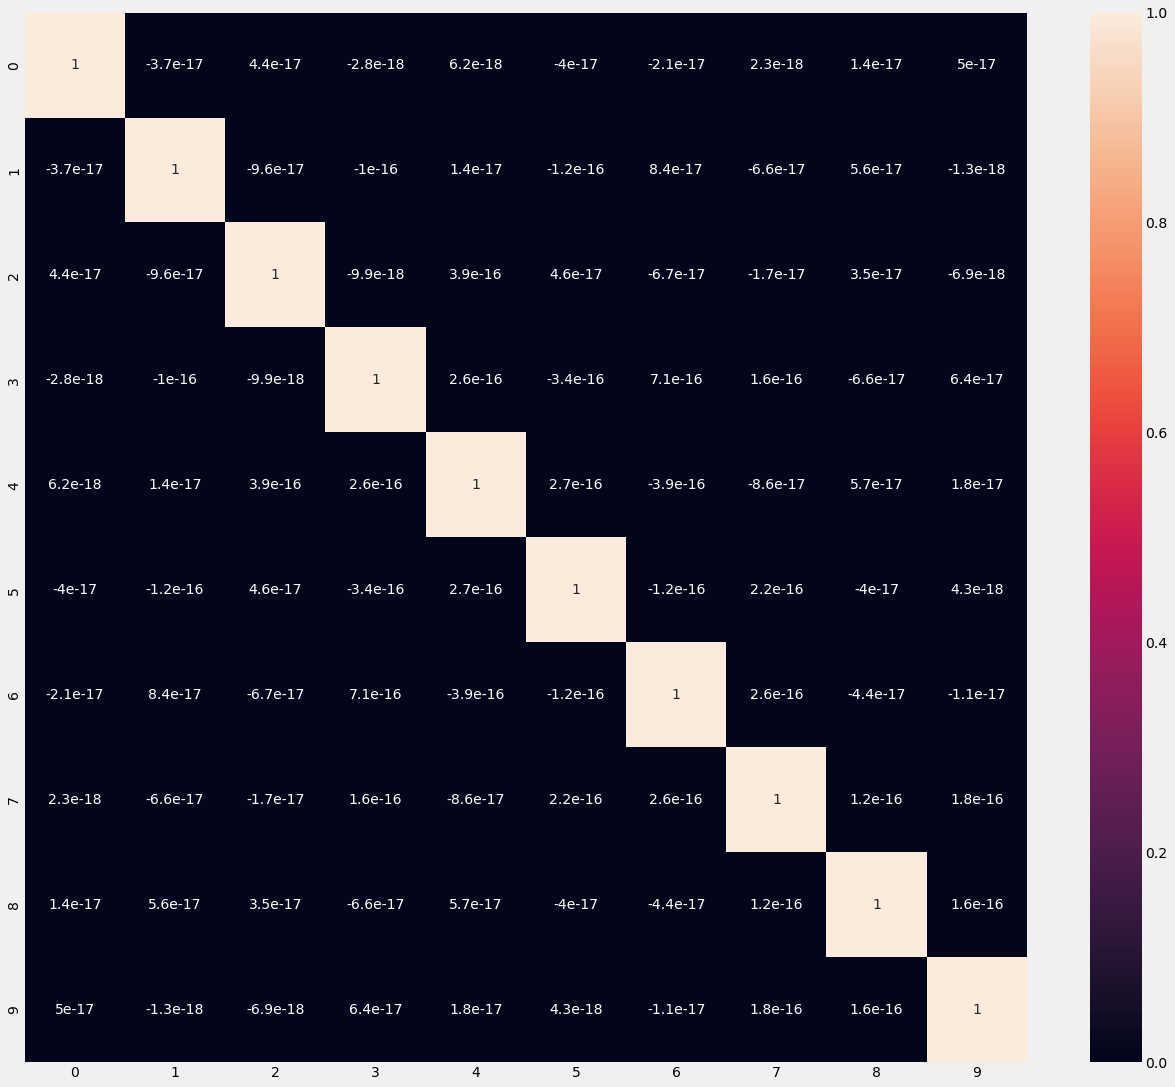

In [52]:
cor_mat_train=data_new.corr(method='pearson')
plt.figure(figsize=(20,18))
import seaborn as sns
sns.heatmap(cor_mat_train, annot=True)
plt.show()

# Mahalanobis distance calculation function

In [54]:
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Mahalanobis distance calculation for test set 1 comparing with mean and covariance values of train (reference) set

In [55]:
df_x = data_new[['0','1','2','3','4','5', '6', '7','8','9']]
df_x['mahala'] = mahalanobis(x=df_x, data=data_vib[['0','1','2','3','4','5', '6', '7','8','9']])
df_x_asc = df_x.sort_values(by=['mahala'], ascending=False)
df_x_asc

C:\Users\Khyati.Thakkar\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning:

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'



,0,1,2,3,4,5,6,7,8,9,mahala
90249,0.198190,6.644708,-3.932873,-0.414070,-3.891953,3.633747,3.272161,1.016023,-2.546020,-0.683691,31.491089
89999,1.269671,6.171535,-3.997096,-0.939202,-4.483986,2.992268,3.326426,1.223699,-2.312889,-0.787110,30.452433
102999,-2.464831,-2.653378,-2.826494,6.850415,-2.441769,-3.867749,-3.146630,-2.541736,0.135008,-0.174655,29.021328
183249,1.222310,-2.086599,-2.596008,4.048172,-4.467936,-0.034689,4.584403,-1.681074,1.731058,0.782532,28.182342
89749,1.753060,5.755258,-4.330911,-0.805371,-3.836089,3.339507,3.570483,1.846045,-1.592035,-0.684465,27.100442
...,...,...,...,...,...,...,...,...,...,...,...
115499,-0.758879,0.334579,0.655157,1.961967,1.096478,-0.069488,0.475205,0.342769,-0.727511,-0.380397,2.647212
26749,-6.021729,-2.002583,2.144868,-0.909305,-0.437667,-0.220721,0.179808,0.431863,-0.493529,-0.278599,2.530441
51499,0.312933,-2.201617,-1.415910,-0.149933,0.476282,-0.984505,-1.290780,0.555241,-0.370282,-0.074237,2.302292
51249,-1.563406,-1.159108,-1.159344,0.189995,0.261382,-1.189336,-1.153288,0.467924,-0.508539,-0.140890,2.018506


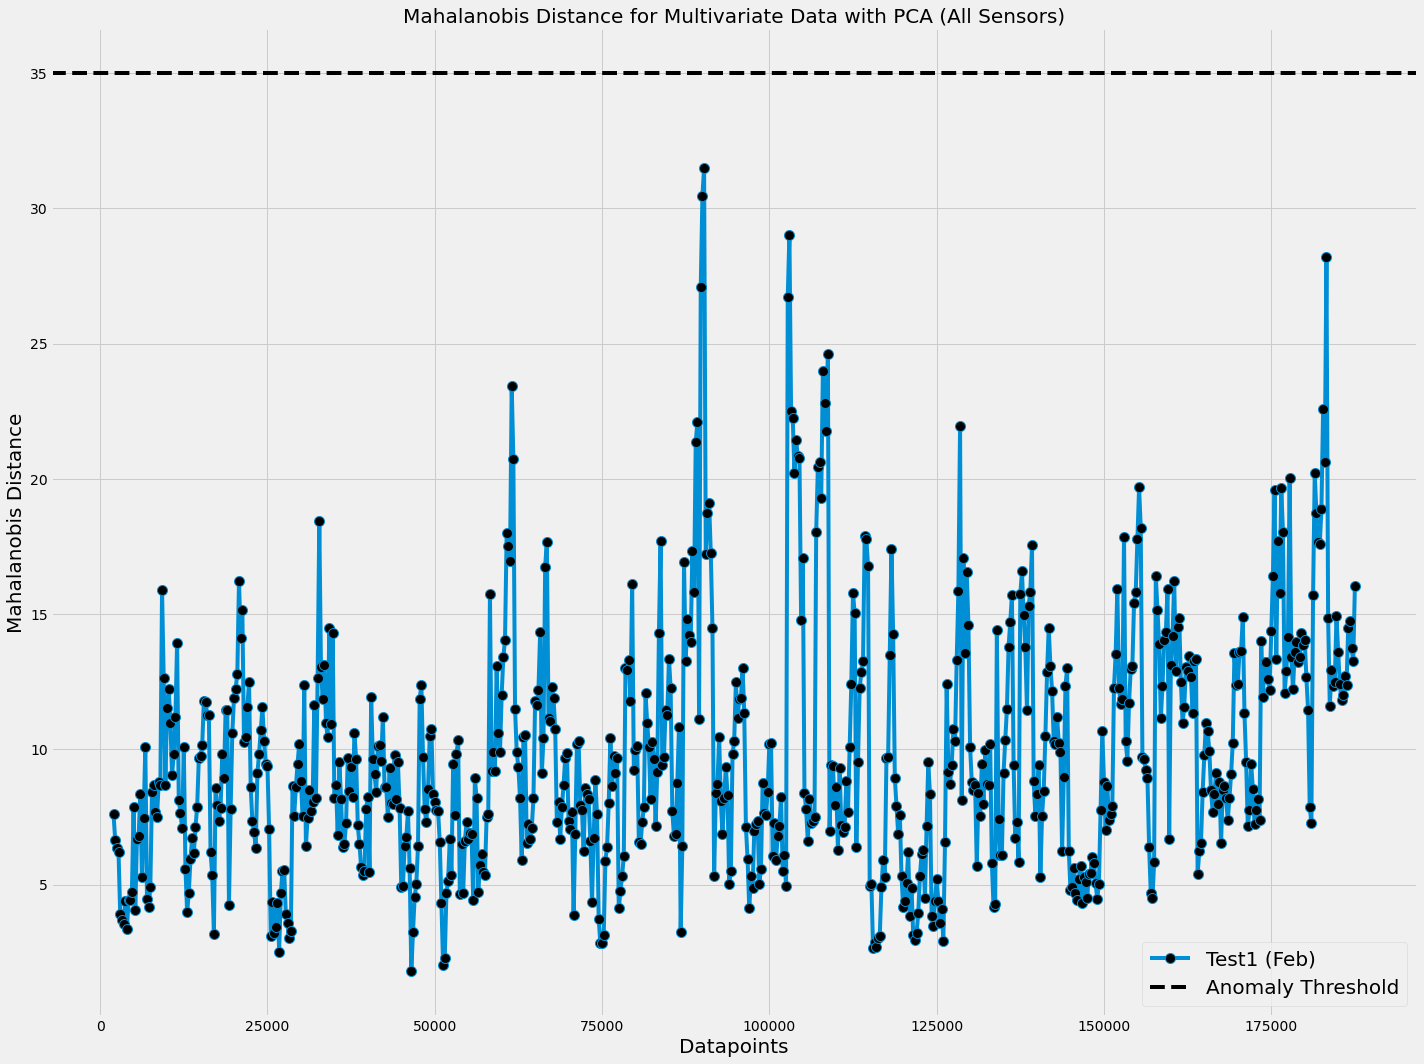

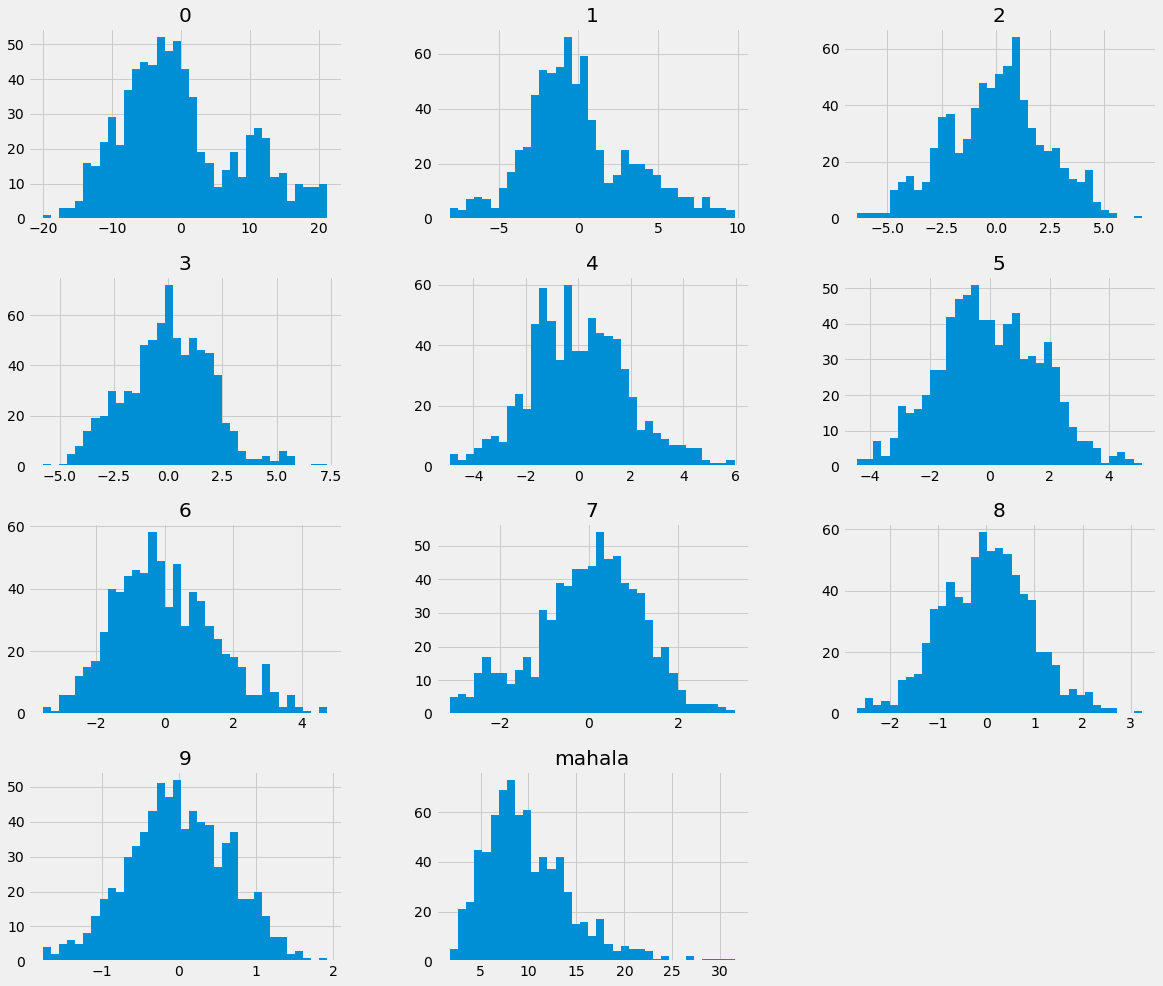

In [61]:
plt.style.use('fivethirtyeight')
ax = df_x['mahala'].plot(figsize=(20,15), marker='o', markersize=10, markerfacecolor='black')
ax.set_xlabel('Datapoints', fontsize=20)
ax.set_ylabel('Mahalanobis Distance', fontsize=20)
ax.set_title('Mahalanobis Distance for Multivariate Data with PCA (All Sensors)', fontsize=20)
ax.legend(fontsize=20)
plt.axhline(35, color='k', linestyle='--')
ax.legend(("Test1 (Feb)", "Anomaly Threshold"), fontsize=20)
plt.tight_layout()

df_x.hist(bins=35, figsize=(18,16))
plt.show()

C:\Users\Khyati.Thakkar\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 0, 'Mahalanobis dist')

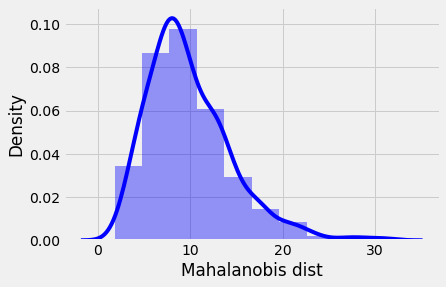

In [58]:
plt.figure()
sns.distplot(df_x['mahala'],
             bins = 10, 
             kde= True, 
            color = 'blue');
plt.xlabel('Mahalanobis dist')

In [62]:
feb = df_x[['mahala']]
feb.columns = ['Feb_Maha']
feb

,Feb_Maha
1999,7.614836
2249,6.662731
2499,6.341282
2749,6.193711
2999,3.926254
...,...
186499,14.506054
186749,14.739638
186999,13.767368
187249,13.262561


In [75]:
feb.to_csv("Output_Data_Files/Multivariate_MahaDist_Rough_With PCA_Feb.csv")
feb

,Feb_Maha
1999,7.614836
2249,6.662731
2499,6.341282
2749,6.193711
2999,3.926254
...,...
186499,14.506054
186749,14.739638
186999,13.767368
187249,13.262561


# Similar analysis is done for March data refered to as test2 data to derive mahalanobis distances for each sensor values in test 2 dataset and is used in further analysis for comparison between test 1 and test 2 datasets

# Compare & plot mahalanobis distances for both test sets (test 1 & test 2)

In [76]:
test1 = pd.read_csv('Output_Data_Files/Multivariate_MahaDist_Rough_With PCA_Feb.csv', index_col=0)
test1

,Feb_Maha
1999,7.614836
2249,6.662731
2499,6.341282
2749,6.193711
2999,3.926254
...,...
186499,14.506054
186749,14.739638
186999,13.767368
187249,13.262561


In [77]:
test2 = pd.read_csv('Output_Data_Files/Multivariate_MahaDist_Rough_With PCA_March.csv', index_col=0)
test2

,March_Maha
1999,29.750256
2249,23.164470
2499,12.913232
2749,11.946190
2999,10.902439
...,...
185499,10.670891
185749,19.088984
185999,15.604545
186249,16.436218


In [67]:
Maha_both = pd.concat([test1,test2], axis=1)
Maha_both

,Feb_Maha,March_Maha
1999,7.614836,29.750256
2249,6.662731,23.164470
2499,6.341282,12.913232
2749,6.193711,11.946190
2999,3.926254,10.902439
...,...,...
186499,14.506054,16.538024
186749,14.739638,NaN
186999,13.767368,NaN
187249,13.262561,NaN


In [68]:
Maha_both.columns =['Test1 (Feb)', 'Test2 (March)']

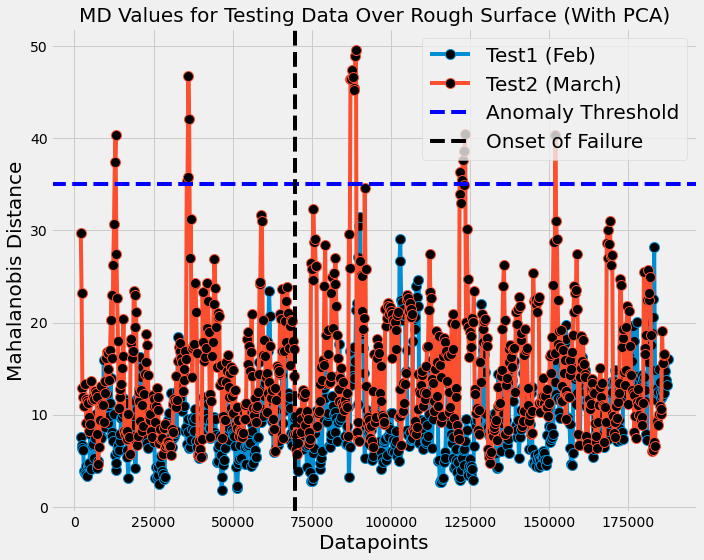

In [71]:
plt.style.use('fivethirtyeight')
ax = Maha_both.plot(figsize=(10,8), marker='o', markersize=10, markerfacecolor='black')
ax.set_xlabel('Datapoints', fontsize=20)
ax.set_ylabel('Mahalanobis Distance', fontsize=20)
ax.set_title('MD Values for Testing Data Over Rough Surface (With PCA)', fontsize=20)
ax.legend(fontsize=20)
plt.axhline(35, color='blue', linestyle='--')
plt.axvline(69849, color='black', linestyle='--')
ax.legend(("Test1 (Feb)", "Test2 (March)", "Anomaly Threshold", "Onset of Failure"), fontsize=20)
plt.tight_layout()